<a href="https://colab.research.google.com/github/tlysenko/ML-notebooks/blob/master/Antibioitic_resistance_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

100k samples of bacterial genomic sequence and resistance to antibiotic

https://www.kaggle.com/drscarlat/dzd-data

## Importing libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import os
import tensorboard
import datetime

from sklearn.metrics import accuracy_score, confusion_matrix

%load_ext tensorboard


## EDA

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/Antibiotics-resistance/data/dataset.npy'
raw_data = np.load(data_path, allow_pickle=True)

In [ ]:
print('data type:', type(raw_data))
print('data dim:', raw_data.ndim)

data type: <class 'numpy.ndarray'>
data dim: 0


In [ ]:
raw_data

array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [ ]:
data_dict = raw_data[()]

In [ ]:
data_dict

{'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
        'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
        'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
        ...,
        'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
        'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
        'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA'],

In [ ]:
df = pd.DataFrame.from_dict(data_dict)
df.genes = df.apply(lambda d: d.genes.lower(), axis = 1) #lowercase genes seqs
df.head()

,resistant,genes
0,False,atgcactaccgtatgatcccccttcactggatgatggaaattgact...
1,False,atgcactaccgtatgattcactggatgatggaaattgactgcaatg...
2,False,atgcactaccgtatgattcactggatcgtgatggaaattgactgca...
3,False,atgcactaccgtatgattcactgggtgatggaaattgactgcaatg...
4,False,atgcacgaccgtatcattcactggatgatggaaattgactgcaatg...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   resistant  100000 non-null  bool  
 1   genes      100000 non-null  object
dtypes: bool(1), object(1)
memory usage: 879.0+ KB


In [ ]:
# No missing values
df.isna().sum()

resistant    0
genes        0
dtype: int64

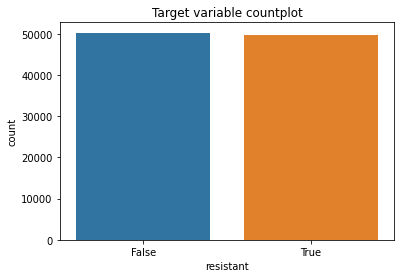

In [ ]:
# Target variable is well balanced
ax = sns.countplot(x = df.resistant);
ax.set_title('Target variable countplot');

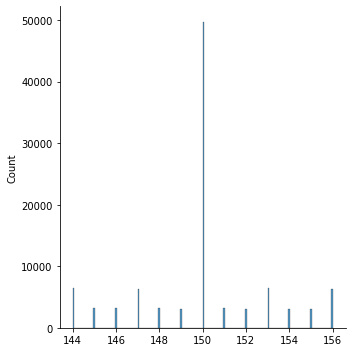

In [ ]:
len_array = [len(seq) for seq in df.genes]
sns.displot(len_array);

### Gene seqs to kmers seqs

Let's transform our input gene sequence into uniform length numerical vectors.

In [ ]:
def GetKmers(k, gene):
  ost = len(gene) % k 
  l = len(gene) - ost - k + 1
  return [gene[i:i+k] for i in range(l)]

In [ ]:
# generating k-mers
df['k5'] = df.apply(lambda x: GetKmers(k=5, gene=x.genes), axis = 1)

In [ ]:
df.head()

,resistant,genes,k5
0,False,atgcactaccgtatgatcccccttcactggatgatggaaattgact...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
1,False,atgcactaccgtatgattcactggatgatggaaattgactgcaatg...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
2,False,atgcactaccgtatgattcactggatcgtgatggaaattgactgca...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
3,False,atgcactaccgtatgattcactgggtgatggaaattgactgcaatg...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
4,False,atgcacgaccgtatcattcactggatgatggaaattgactgcaatg...,"[atgca, tgcac, gcacg, cacga, acgac, cgacc, gac..."


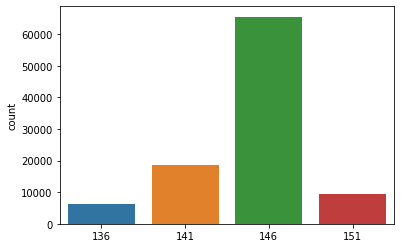

In [ ]:
len_ = [len(seq) for seq in df.k5]
sns.countplot(x = len_);

## Data Prep pipeline # 1 

- Count Vectorizer
- k = 5

In [ ]:
def GetKmers(k, gene):
  ost = len(gene) % k 
  l = len(gene) - ost - k + 1
  return [gene[i:i+k] for i in range(l)]

  

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/Antibiotics-resistance/data/dataset.npy'
raw_data = np.load(data_path, allow_pickle=True)

data_dict = raw_data[()]

df = pd.DataFrame.from_dict(data_dict)
df.genes = df.apply(lambda d: d.genes.lower(), axis = 1) #lowercase genes seqs
df['k5'] = df.apply(lambda x: GetKmers(k=5, gene=x.genes), axis = 1)
df.head()

,resistant,genes,k5
0,False,atgcactaccgtatgatcccccttcactggatgatggaaattgact...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
1,False,atgcactaccgtatgattcactggatgatggaaattgactgcaatg...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
2,False,atgcactaccgtatgattcactggatcgtgatggaaattgactgca...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
3,False,atgcactaccgtatgattcactgggtgatggaaattgactgcaatg...,"[atgca, tgcac, gcact, cacta, actac, ctacc, tac..."
4,False,atgcacgaccgtatcattcactggatgatggaaattgactgcaatg...,"[atgca, tgcac, gcacg, cacga, acgac, cgacc, gac..."


In [ ]:
# Count Vectorizer 
text_corpus = list(df.k5)
for i in range(len(text_corpus)):
  text_corpus[i] = ' '.join(text_corpus[i])
  

CntVect = CountVectorizer(analyzer='word')

X = CntVect.fit_transform(text_corpus).toarray()
y = df.resistant.astype('int')

In [ ]:
# Sample validation 
dd = pd.DataFrame(data = X)
dd['target'] = y

#Shufle the dataframe
dd = dd.sample(frac = 1)

#Split the dataframe 0.7, 0.2, 0.1 
y_train = tf.convert_to_tensor(dd['target'][:70000])
y_test = tf.convert_to_tensor(dd['target'][70000:90000])
y_val = tf.convert_to_tensor(dd['target'][90000:])

dd.drop('target',axis=1, inplace=True)
X_train = tf.convert_to_tensor( dd.iloc[0:70000, :] )
X_test = tf.convert_to_tensor(dd.iloc[70000:90000, :])
X_val = tf.convert_to_tensor(dd.iloc[90000:, :] )

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 1024) (70000,)
(20000, 1024) (20000,)


In [ ]:
print(X_test)
print(X_train)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(20000, 1024), dtype=int64)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(70000, 1024), dtype=int64)


In [ ]:
print(y_train)
print(y_test)

tf.Tensor([0 0 1 ... 1 0 0], shape=(70000,), dtype=int64)
tf.Tensor([0 1 1 ... 1 0 1], shape=(20000,), dtype=int64)


## Data Prep Function


In [8]:
def DataPrepCntVct(k):
  def GetKmers(k, gene):
    ost = len(gene) % k 
    l = len(gene) - ost - k + 1
    return [gene[i:i+k] for i in range(l)]

  
  data_path = '/content/drive/MyDrive/ColabNotebooks/Antibiotics-resistance/data/dataset.npy'
  raw_data = np.load(data_path, allow_pickle=True)
  data_dict = raw_data[()]

  df = pd.DataFrame.from_dict(data_dict)
  df.genes = df.apply(lambda d: d.genes.lower(), axis = 1) #lowercase genes seqs
  df['kmers'] = df.apply(lambda x: GetKmers(k=k, gene=x.genes), axis = 1)

  # Count Vectorizer 
  text_corpus = list(df.kmers)
  for i in range(len(text_corpus)):
    text_corpus[i] = ' '.join(text_corpus[i])
    

  CntVect = CountVectorizer(analyzer='word')

  X = CntVect.fit_transform(text_corpus).toarray()
  y = df.resistant.astype('int')
  if np.max(X)<128 and np.min(X)>-128:
    X = X.astype('int8')
    y = y.astype('int8')

  return X, y

## Model 1: Baseline

In [ ]:
print(len(CntVect.vocabulary_))

1024


In [ ]:
# TF model 
model = keras.Sequential()
model.add(layers.Embedding(input_dim=len(CntVect.vocabulary_), output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          65536     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 164,481
Trainable params: 164,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss = lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(
    y_true, y_pred, from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
! rm -rf ./logs/

tf.random.set_seed(999)
num_epochs = 20

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir /content/logs 

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_data=(X_val, y_val),
    callbacks = [tensorboard_callback]
)

Reusing TensorBoard on port 6006 (pid 1416), started 4:28:40 ago. (Use '!kill 1416' to kill it.)

<IPython.core.display.Javascript object>

Epoch 1/20
1094/1094 [==============================] - 78s 70ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.5035 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5041
Epoch 2/20
1094/1094 [==============================] - 76s 69ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5050 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.5041
Epoch 3/20
1094/1094 [==============================] - 78s 71ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.5042 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5041
Epoch 4/20
1094/1094 [==============================] - 78s 71ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5030 - val_loss: 0.6939 - val_sparse_categorical_accuracy: 0.5041
Epoch 5/20
1094/1094 [==============================] - 78s 71ms/step - loss: 0.6939 - sparse_categorical_accuracy: 0.5044 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.5041
Epoch 6/20
1094/1094 [==============================] - 78s 71ms/step - loss: 0.

In [ ]:
prediction = model.predict(X_test)

In [ ]:
round_prediction = [0 if x < 0.5 else 1 for x in prediction]

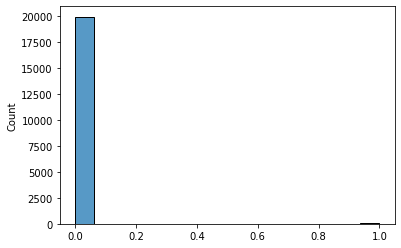

In [ ]:
sns.histplot(round_prediction);

In [ ]:
accuracy_score(y_test.numpy(), round_prediction)

0.4966

In [ ]:
print(confusion_matrix(y_test.numpy(), round_prediction))

[[ 9932    67]
 [10001     0]]


In [ ]:
# The model is not performing well

## Model 2: MultinomialNB


In [4]:
def MNB(X,y, alpha):

  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=999)
  
  
  classifier = MultinomialNB(alpha=alpha)
  classifier.fit(X_train, y_train)
  
  prediction = classifier.predict(X_test)

  return accuracy_score(y_test, prediction)

In [6]:
accuracy_ = []
for k in range (3,8):
  print('k',k)
  X, y = DataPrepCntVct(k)
  acc = MNB(X,y, 0.1)
  print('acc', acc)
  accuracy_.append(acc)

k 3
acc 0.62685
k 4
acc 0.6895
k 5
acc 0.7212
k 6
acc 0.803
k 7
acc 0.8352


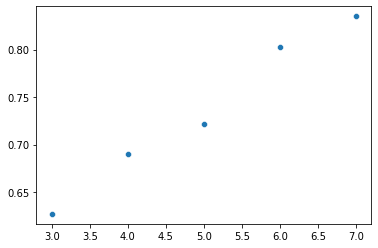

In [9]:
sns.scatterplot(x = range(3,8), y = accuracy_);

In [13]:
X, y = DataPrepCntVct(k=7)
alphaRange = [0.1, 0.2, 0.5, 0.8, 1]
accuracy_ = []
for alpha in alphaRange:
  acc = MNB(X,y, alpha)
  accuracy_.append(acc)

In [14]:
print(accuracy_)

[0.8352, 0.83475, 0.834, 0.8331, 0.8322]


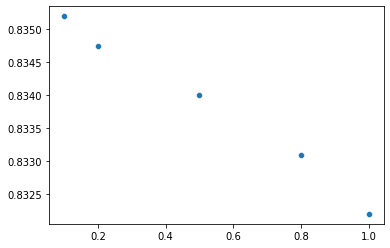

In [15]:
sns.scatterplot(x = alphaRange, y = accuracy_);

In [18]:
# alpha = 0.1 for k=7 is an optimal hyperparameter value for 0.8352 accuracy

## Model 3: MultinomialNB with batching for k > 8

In [28]:
X, y = DataPrepCntVct(k=7)

In [29]:
# Size of my data
print('Dataset size', X.size*X.itemsize*10**(-9), 'Gb')
print('Dataset size, k=6', X.size*(4**6)*10**(-9), 'Gb')
print('Dataset size, k=7', X.size*(4**7)*10**(-9), 'Gb')

print('Dataset sample size', X.itemsize*(4**7), 'bytes')

Dataset size 1.5328000000000002 Gb
Dataset size, k=6 6278.348800000001 Gb
Dataset size, k=7 25113.395200000003 Gb
Dataset sample size 16384 bytes


In [20]:
# Size of my data
print('Dataset size', X.size*X.itemsize*10**(-9), 'Gb')
print('Dataset size, k=6', X.size*(4**6)*10**(-9), 'Gb')
print('Dataset size, k=7', X.size*(4**7)*10**(-9), 'Gb')

print('Dataset sample size', X.itemsize*(4**7), 'bytes')

Dataset size 12.262400000000001 Gb
Dataset size, k=6 6278.348800000001 Gb
Dataset size, k=7 25113.395200000003 Gb
Dataset sample size 131072 bytes


In [21]:
np.max(X), np.min(X)

(3, 0)

In [4]:
def MNB-batching(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=999)
  
  
  
  print(X_train.shape, y_train.shape)
  print(X_test.shape, y_test.shape)

  classifier = MultinomialNB(alpha=0.1)

  n = 1

  for i in range(0,1):
    #
    print(i)
    print(X_train[i * n : (i+1)*n ,:].shape, y_train[i*n: (i+1)*n].shape)
    classifier.fit(X_train[i * n : (i+1)*n ,:], y_train[i*n: (i+1)*n]) #, classes = (0,1))

  # for i in range(0,0):
  #   #classifier.fit(X_train, y_train)
  #   classifier.fit(X_train[i * n : (i+1)*n ,:], y_train[i*n: (i+1)*n], classes = (0,1))


  prediction = classifier.predict(X_test)

  return accuracy_score(y_test, prediction)

In [5]:
X, y = DataPrepCntVct(k=7)

In [28]:
# Size of my data
print('Dataset size', X.size*X.itemsize*10**(-9), 'Gb')
print('Dataset size, k=6', X.size*(4**6)*10**(-9), 'Gb')
print('Dataset size, k=7', X.size*(4**7)*10**(-9), 'Gb')

print('Dataset sample size', X.itemsize*(4**7), 'bytes')

Dataset size 12.262400000000001 Gb
Dataset size, k=6 6278.348800000001 Gb
Dataset size, k=7 25113.395200000003 Gb
Dataset sample size 131072 bytes


In [ ]:
xsh=[]
for i in range(4,9):
  X, y = DataPrepCntVct(k=i)
  print(i, ':', X.shape)
  xsh.append(X.shape[1])

4 : (100000, 256)
5 : (100000, 1024)
6 : (100000, 4096)
7 : (100000, 15328)


## Model 4: deeper network 

In [ ]:
# TF model 
model2 = keras.Sequential()
model2.add(layers.Embedding(input_dim=len(CntVect.vocabulary_), output_dim=64))
model2.add(layers.LSTM(128))
model2.add(layers.Dense(1))
model2.summary()

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(),  
    loss = lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(
    y_true, y_pred, from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
! rm -rf ./logs/

tf.random.set_seed(999)
num_epochs = 20

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir /content/logs 

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_data=(X_val, y_val),
    callbacks = [tensorboard_callback]
)